From: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

2024-09-23 18:02:05.494286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 18:02:05.511804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 18:02:05.517013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 18:02:05.529864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 18:02:06.235336: W tensorflow/comp

In [2]:
print(tf.__version__)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.17.0


In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [5]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [6]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

/rishic/anaconda3/envs/spark-rapids-tf-andcuda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [9]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

2024-09-23 18:02:10.729230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30483 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:34:00.0, compute capability: 7.0
2024-09-23 18:02:10.730667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30515 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:36:00.0, compute capability: 7.0
2024-09-23 18:02:10.731982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30515 MB memory:  -> device: 2, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:39:00.0, compute capability: 7.0
2024-09-23 18:02:10.733270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30515 MB memory:  -> device: 3, name: Tesla V100-SXM3-32GB-H, pc

In [10]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[ 6]
 [12]
 [ 1]
 [ 2]
 [12]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)


2024-09-23 18:02:10.892870: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [12]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

2024-09-23 18:02:14.813033: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.43022144],
       [-0.19569683],
       [ 0.43022144],
       [-0.8216151 ],
       [-0.19569683]], dtype=float32)>

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [14]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [15]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

2024-09-23 18:02:18.350486: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [16]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [17]:
all_inputs = {}
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs[header] = numeric_col
    encoded_features.append(encoded_numeric_col)

In [18]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs['Age'] = age_col
encoded_features.append(encoded_age_col)

In [19]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs[header] = categorical_col
    encoded_features.append(encoded_categorical_col)

2024-09-23 18:02:19.040059: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-23 18:02:20.170561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"],
              run_eagerly=True)

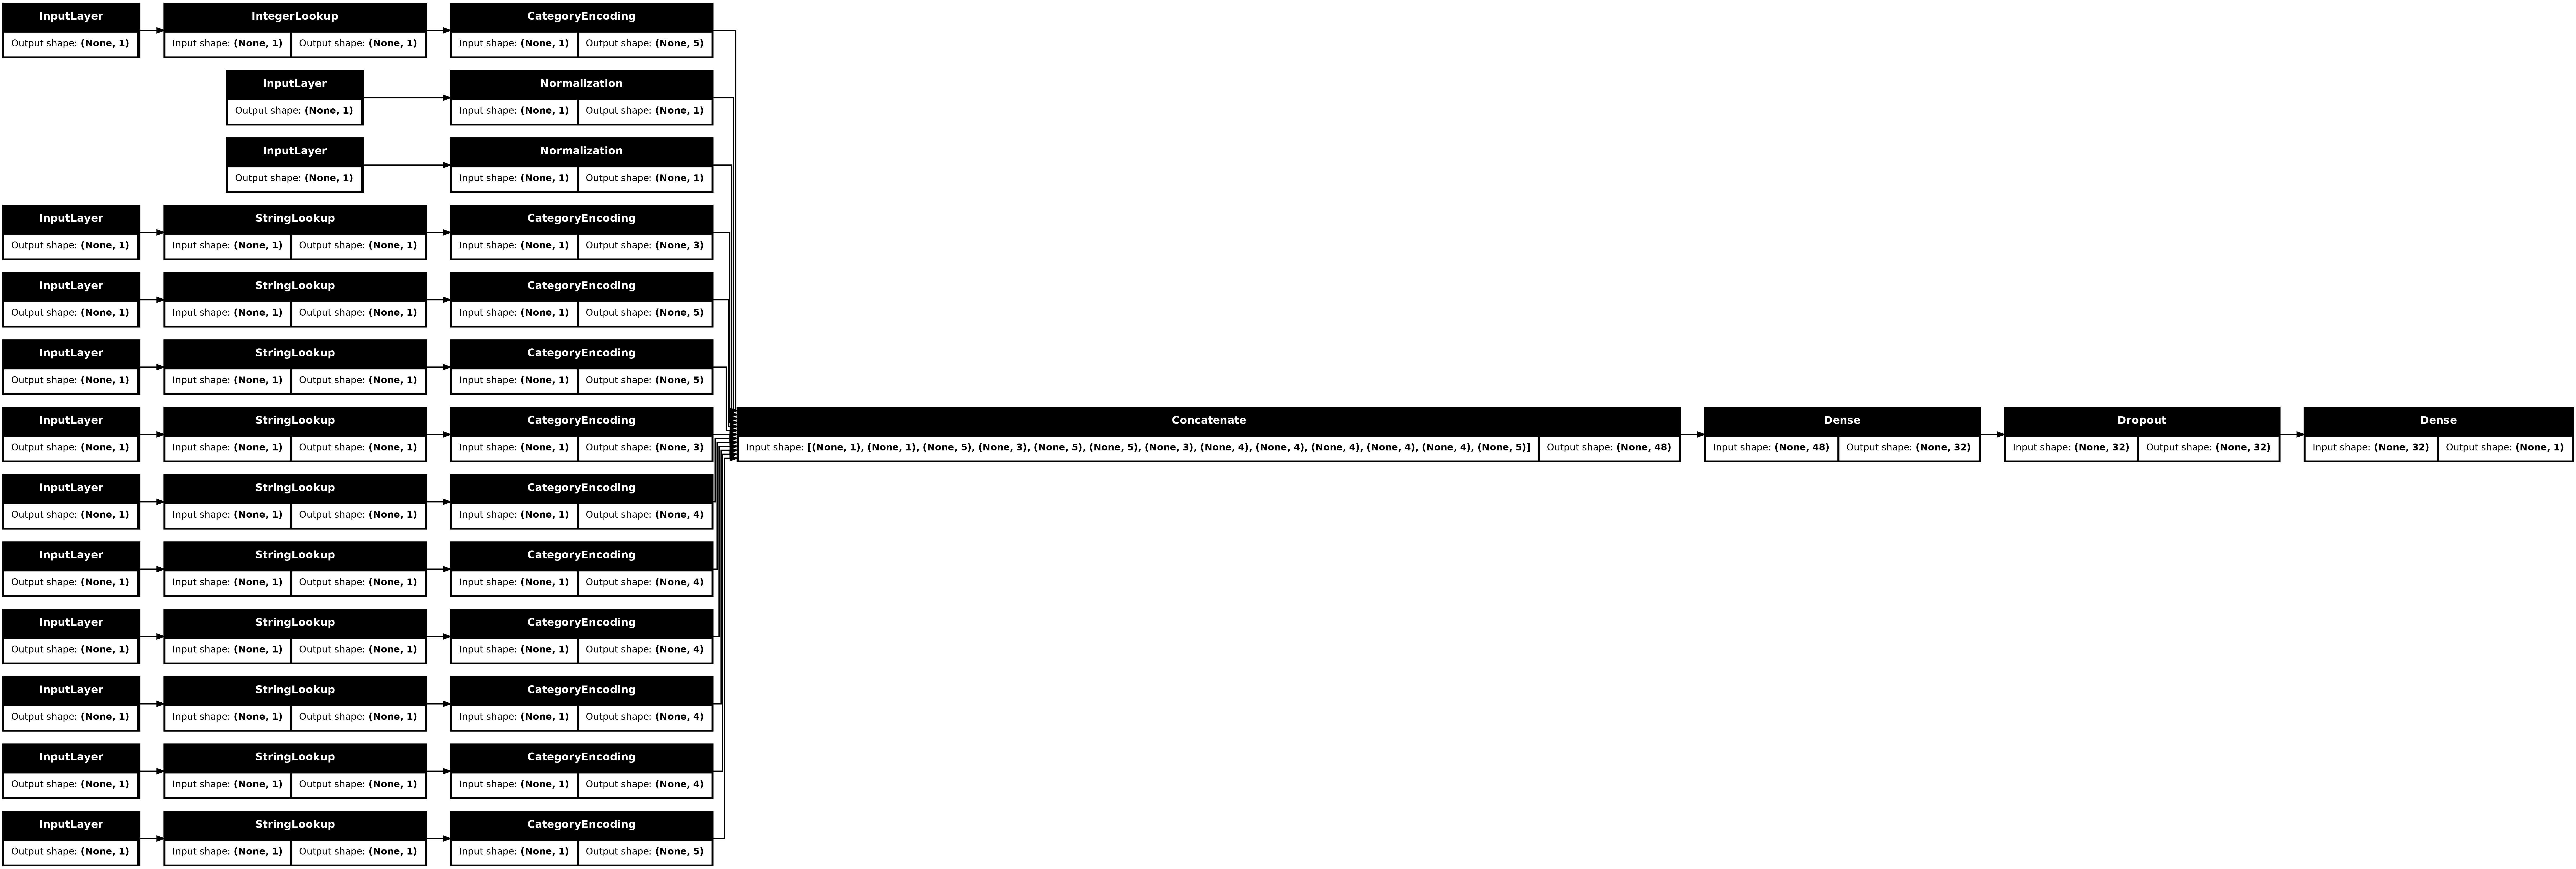

In [22]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [23]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5000 - loss: 0.6308 - val_accuracy: 0.7340 - val_loss: 0.5365
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6776 - loss: 0.5731 - val_accuracy: 0.7340 - val_loss: 0.5250
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6846 - loss: 0.5608 - val_accuracy: 0.7383 - val_loss: 0.5181
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7057 - loss: 0.5425 - val_accuracy: 0.7366 - val_loss: 0.5142
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7097 - loss: 0.5380 - val_accuracy: 0.7366 - val_loss: 0.5112
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7095 - loss: 0.5404 - val_accuracy: 0.7374 - val_loss: 0.5081
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7198 - loss: 0.5286 - val_accuracy: 0.7374 - val_loss: 0.5050
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7304 - loss: 0.5155 - val_accuracy: 0.7357 - v

In [24]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7266 - loss: 0.5541

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7383 - loss: 0.5230
Accuracy 0.7357019186019897


## Save and Reload Model

In [25]:
import tensorflow as tf

In [26]:
model.save('my_pet_classifier.keras')

In [27]:
reloaded_model = tf.keras.models.load_model('my_pet_classifier.keras')

In [28]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
This particular pet had a 74.4 percent probability of getting adopted.


## PySpark

In [29]:
from pyspark.sql import SparkSession

num_threads = 6

# Creating a local Spark session for demonstration, in case it hasn't already been created.

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "20g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.python.worker.reuse": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/23 18:02:40 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/23 18:02:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/23 18:02:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/23 18:02:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [30]:
df = spark.createDataFrame(dataframe)

In [31]:
df.write.mode("overwrite").parquet("datasets/petfinder-mini")

In [32]:
df.show()

+----+---+--------------------+------+------+--------+------------+---------+----------+----------+-------+---+--------+------+
|Type|Age|              Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized| Health|Fee|PhotoAmt|target|
+----+---+--------------------+------+------+--------+------------+---------+----------+----------+-------+---+--------+------+
| Cat|  3|               Tabby|  Male| Black|   White|       Small|    Short|        No|        No|Healthy|100|       1|     1|
| Cat|  1|Domestic Medium Hair|  Male| Black|   Brown|      Medium|   Medium|  Not Sure|  Not Sure|Healthy|  0|       2|     1|
| Dog|  1|         Mixed Breed|  Male| Brown|   White|      Medium|   Medium|       Yes|        No|Healthy|  0|       7|     1|
| Dog|  4|         Mixed Breed|Female| Black|   Brown|      Medium|    Short|       Yes|        No|Healthy|150|       8|     1|
| Dog|  1|         Mixed Breed|  Male| Black|No Color|      Medium|    Short|        No|        No|Healt

## Inference using Spark DL API

In [33]:
import numpy as np
import os

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col
from pyspark.sql.types import ArrayType, FloatType

In [34]:
df = spark.read.parquet("datasets/petfinder-mini").cache()
df.show(5)

+----+---+------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+
|Type|Age|            Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized|      Health|Fee|PhotoAmt|target|
+----+---+------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+
| Dog|  7|       Mixed Breed|Female| Black|   Brown|      Medium|    Short|        No|       Yes|     Healthy|  0|       2|     1|
| Dog| 24|       Mixed Breed|Female| Brown|No Color|       Large|   Medium|       Yes|       Yes|     Healthy|  0|       3|     0|
| Dog| 61|      Irish Setter|Female| Brown|  Golden|       Large|     Long|       Yes|       Yes|     Healthy|  0|       2|     1|
| Dog|  3|       Mixed Breed|  Male| Brown|  Golden|      Medium|    Short|       Yes|  Not Sure|Minor Injury|  0|       9|     0|
| Dog|  5|Miniature Pinscher|Female| Black|   Brown|       Small|    Short|       Y

In [35]:
columns = df.columns
print(columns)

['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']


In [36]:
# remove label column
columns.remove("target")
print(columns)

['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']


In [37]:
# get absolute path to model
model_dir = "{}/my_pet_classifier.keras".format(os.getcwd())

In [38]:
def predict_batch_fn():
    import tensorflow as tf
    import pandas as pd
    
    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = tf.keras.models.load_model(model_dir)

    def predict(t, a, b, g, c1, c2, m, f, v, s, h, fee, p):
        inputs = {
            "Type": t,
            "Age": a,
            "Breed1": b,
            "Gender": g,
            "Color1": c1,
            "Color2": c2,
            "MaturitySize": m,
            "FurLength": f,
            "Vaccinated": v,
            "Sterilized": s,
            "Health": h,
            "Fee": fee,
            "PhotoAmt": p
        }
        # return model.predict(inputs)
        return pd.Series(np.squeeze(model.predict(inputs)))

    return predict

In [39]:
# need to pass the list of columns into the model_udf
classify = predict_batch_udf(predict_batch_fn,
                             return_type=FloatType(),
                             batch_size=100)

In [40]:
%%time
preds = df.withColumn("preds", classify(struct(*columns)))
results = preds.collect()

24/09/23 18:02:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-09-23 18:02:49.459288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 18:02:49.460271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 18:02:49.460273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 18:02:49.461689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one

CPU times: user 162 ms, sys: 152 ms, total: 314 ms
Wall time: 37.2 s


In [41]:
%%time
preds = df.withColumn("preds", classify(*columns))
results = preds.collect()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step  6) / 6]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepp
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━

CPU times: user 250 ms, sys: 70.8 ms, total: 321 ms
Wall time: 7.06 s


In [42]:
%%time
preds = df.withColumn("preds", classify(*[col(c) for c in columns]))
results = preds.collect()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepp
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step+ 6) / 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━

CPU times: user 83.9 ms, sys: 42.3 ms, total: 126 ms
Wall time: 7.26 s


In [43]:
preds.show()

+----+---+--------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+-----------+
|Type|Age|              Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized|      Health|Fee|PhotoAmt|target|      preds|
+----+---+--------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+-----------+
| Dog|  7|         Mixed Breed|Female| Black|   Brown|      Medium|    Short|        No|       Yes|     Healthy|  0|       2|     1|-0.35085946|
| Dog| 24|         Mixed Breed|Female| Brown|No Color|       Large|   Medium|       Yes|       Yes|     Healthy|  0|       3|     0| -0.1520063|
| Dog| 61|        Irish Setter|Female| Brown|  Golden|       Large|     Long|       Yes|       Yes|     Healthy|  0|       2|     1|  0.9889738|
| Dog|  3|         Mixed Breed|  Male| Brown|  Golden|      Medium|    Short|       Yes|  Not Sure|Minor Injury|  0|       9|     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

This notebook uses the [Python backend with a custom execution environment](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments) for Triton 24.08, using a conda-pack environment created as follows:
```
conda create -n tf-gpu -c conda-forge python=3.10.0
conda activate tf-gpu

export PYTHONNOUSERSITE=True
pip install numpy==1.26.4 tensorflow[and-cuda] conda-pack

conda pack  # tf-gpu.tar.gz
```

In [44]:
import numpy as np
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [135]:
%%bash
# copy custom model to expected layout for Triton
sudo rm -rf models
mkdir -p models
cp -r models_config/feature_columns models

# add custom execution environment
cp tf-gpu.tar.gz models

#### Start Triton Server on each executor

In [136]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
my_pet_classifier_dir = "{}/my_pet_classifier.keras".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="128M",
            volumes={
                triton_models_dir: {"bind": "/models", "mode": "ro"},
                my_pet_classifier_dir: {"bind": "/my_pet_classifier.keras", "mode": "ro"}
            }
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: b24a032f9568                                  (0 + 1) / 1]


[True]

#### Run inference

In [137]:
df = spark.read.parquet("datasets/petfinder-mini")

In [138]:
df.show(5)

+----+---+------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+
|Type|Age|            Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized|      Health|Fee|PhotoAmt|target|
+----+---+------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+
| Dog|  7|       Mixed Breed|Female| Black|   Brown|      Medium|    Short|        No|       Yes|     Healthy|  0|       2|     1|
| Dog| 24|       Mixed Breed|Female| Brown|No Color|       Large|   Medium|       Yes|       Yes|     Healthy|  0|       3|     0|
| Dog| 61|      Irish Setter|Female| Brown|  Golden|       Large|     Long|       Yes|       Yes|     Healthy|  0|       2|     1|
| Dog|  3|       Mixed Breed|  Male| Brown|  Golden|      Medium|    Short|       Yes|  Not Sure|Minor Injury|  0|       9|     0|
| Dog|  5|Miniature Pinscher|Female| Black|   Brown|       Small|    Short|       Y

In [139]:
columns = df.columns
print(columns)

['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']


In [140]:
# remove label column
columns.remove("target")
print(columns)

['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']


In [141]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(t, a, b, g, c1, c2, m, f, v, s, h, fee, p):
        # convert input ndarrays into a dictionary of ndarrays
        inputs = {
            "Type": t, 
            "Age": a, 
            "Breed1": b, 
            "Gender": g,
            "Color1": c1,
            "Color2": c2,
            "MaturitySize": m,
            "FurLength": f,
            "Vaccinated": v, 
            "Sterilized": s,
            "Health": h,
            "Fee": fee,
            "PhotoAmt": p
        }
        return _predict(inputs)
        
    def _predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
        
    return predict

In [142]:
from functools import partial

# need to pass the list of columns into the model_udf
classify = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="feature_columns"),
                             input_tensor_shapes=[[1]] * len(columns),
                             return_type=FloatType(),
                             batch_size=1024)

In [143]:
# FAILS: Op type not registered 'DenseBincount' WITHOUT custom python backend
df.withColumn("preds", classify(struct(*columns))).show(truncate=10)

/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


+----+---+----------+------+------+--------+------------+---------+----------+----------+----------+---+--------+------+----------+
|Type|Age|    Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized|    Health|Fee|PhotoAmt|target|     preds|
+----+---+----------+------+------+--------+------------+---------+----------+----------+----------+---+--------+------+----------+
| Dog|  7|Mixed B...|Female| Black|   Brown|      Medium|    Short|        No|       Yes|   Healthy|  0|       2|     1|-0.3508...|
| Dog| 24|Mixed B...|Female| Brown|No Color|       Large|   Medium|       Yes|       Yes|   Healthy|  0|       3|     0|-0.1520063|
| Dog| 61|Irish S...|Female| Brown|  Golden|       Large|     Long|       Yes|       Yes|   Healthy|  0|       2|     1| 0.9889738|
| Dog|  3|Mixed B...|  Male| Brown|  Golden|      Medium|    Short|       Yes|  Not Sure|Minor I...|  0|       9|     0|  0.515336|
| Dog|  5|Miniatu...|Female| Black|   Brown|       Small|    Short|       Ye

In [144]:
%%time
preds = df.withColumn("preds", classify(struct(*columns)))
results = preds.collect()

/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_3507224/3574973703.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


CPU times: user 65.9 ms, sys: 37.4 ms, total: 103 ms
Wall time: 7.43 s


In [145]:
%%time
preds = df.withColumn("preds", classify(*columns))
results = preds.collect()

CPU times: user 62.5 ms, sys: 33.4 ms, total: 95.9 ms
Wall time: 6.82 s


In [146]:
%%time
preds = df.withColumn("preds", classify(*[col(c) for c in columns]))
results = preds.collect()

CPU times: user 48.5 ms, sys: 39.7 ms, total: 88.1 ms
Wall time: 6.7 s


In [147]:
preds.show()

+----+---+--------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+-----------+
|Type|Age|              Breed1|Gender|Color1|  Color2|MaturitySize|FurLength|Vaccinated|Sterilized|      Health|Fee|PhotoAmt|target|      preds|
+----+---+--------------------+------+------+--------+------------+---------+----------+----------+------------+---+--------+------+-----------+
| Dog|  7|         Mixed Breed|Female| Black|   Brown|      Medium|    Short|        No|       Yes|     Healthy|  0|       2|     1|-0.35085946|
| Dog| 24|         Mixed Breed|Female| Brown|No Color|       Large|   Medium|       Yes|       Yes|     Healthy|  0|       3|     0| -0.1520063|
| Dog| 61|        Irish Setter|Female| Brown|  Golden|       Large|     Long|       Yes|       Yes|     Healthy|  0|       2|     1|  0.9889738|
| Dog|  3|         Mixed Breed|  Male| Brown|  Golden|      Medium|    Short|       Yes|  Not Sure|Minor Injury|  0|       9|     

#### Stop Triton Server on each executor

In [148]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['b24a032f9568']


[True]

In [149]:
spark.stop()